In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import datetime
import csv
import matplotlib.cm as cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

dataset = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_GOOG.csv")
print("Original dataset:\n",dataset.head())
print("\nShape of data: ",dataset.shape)
print("\nThe keys in our data set:",dataset.keys())

Original dataset:
              timestamp  value
0  2015-02-26 21:42:53     35
1  2015-02-26 21:47:53     41
2  2015-02-26 21:52:53     32
3  2015-02-26 21:57:53     36
4  2015-02-26 22:02:53     32

Shape of data:  (15842, 2)

The keys in our data set: Index(['timestamp', 'value'], dtype='object')


In [2]:
'''Here is the type of data we are dealing with for this project. \
As we can see there are only two columns, timestamp and value. \
There are 15842 entries in the dataset that will need to be analyzed'''

'Here is the type of data we are dealing with for this project. As we can see there are only two columns, timestamp and value. There are 15842 entries in the dataset that will need to be analyzed'

In [3]:
time = dataset["timestamp"]
values = dataset["value"]
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])
print("A description of the data set:")
dataset["timestamp"].describe()

A description of the data set:


count                   15842
unique                  15842
top       2015-04-17 21:57:53
freq                        1
first     2015-02-26 21:42:53
last      2015-04-22 21:47:53
Name: timestamp, dtype: object

In [4]:
#Here we see a further description of what is contained within our dataset

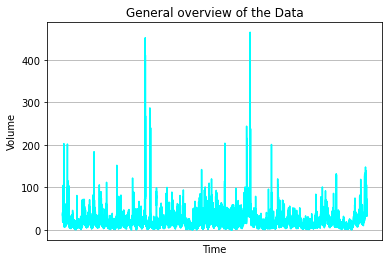

In [5]:
figure, temp = plt.subplots()
temp.plot(dataset.index, dataset['value'], linestyle="solid", color='cyan')
dates = mdates.YearLocator()
datesFormat = mdates.DateFormatter('%Y')
temp.xaxis.set_major_locator(dates)
temp.xaxis.set_major_formatter(datesFormat)
temp.set(xlabel='Time', ylabel='Volume',title='General overview of the Data')
temp.grid(True)

In [6]:
'''This is a graphical representation generalizing the data within the dataset\
Clearly there are some extreme outliers within the dataset that will be detected\
using anomaly detection methods below'''

'This is a graphical representation generalizing the data within the datasetClearly there are some extreme outliers within the dataset that will be detectedusing anomaly detection methods below'

In [7]:
tweets = dataset["value"].values
tweetsLen = len(tweets)
tweets = tweets[(tweetsLen//8):tweetsLen-(tweetsLen//8)]
tweetAvg = int(np.floor(tweets.mean()))
print("Average number of tweets in a 30 minute window: ",tweetAvg)
stdDev = tweets.std()
print(f'Standard deviation within the 30 minute window: {stdDev:.2f}')
dataset["scores"] = np.power(((dataset["value"] - tweetAvg)/tweetAvg), 2)
print('\nDescription of the "scores" portion of the data set:')
dataset["scores"].describe()

Average number of tweets in a 30 minute window:  20
Standard deviation within the 30 minute window: 18.95

Description of the "scores" portion of the data set:


count    15842.000000
mean         0.862915
std          8.134485
min          0.000000
25%          0.040000
50%          0.160000
75%          0.422500
max        495.062500
Name: scores, dtype: float64

The most activity occurred on:

timestamp    2015-04-01 19:17:53
value                        465
scores                   495.062
Name: 9763, dtype: object


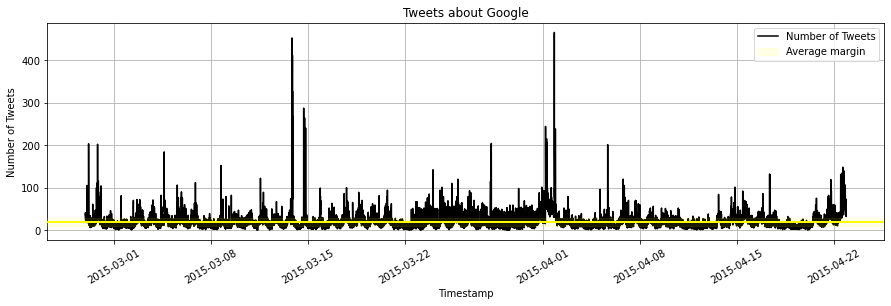

In [8]:
line1 = 'Number of Tweets'
line2 = 'Average margin'
tempData = dataset.apply(lambda row: np.array(list((row["timestamp"], row["value"], row["scores"]))), axis=1)
tempData = np.array(list(tempData))
plt.figure(figsize=(15, 4))
plt.plot(tempData[:,0], tempData[:,1], color='black', linestyle='solid')
plt.axhspan(tweetAvg - (stdDev / 2), tweetAvg + (stdDev / 2),
             color="yellow", alpha=0.1, zorder=5)
plt.axhspan(tweetAvg - 1, tweetAvg + 1, color="yellow", zorder=6)
plt.title("Tweets about Google")
plt.xlabel("Timestamp")
plt.xticks(rotation=30)
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.legend((line1, line2),loc='best')
print("The most activity occurred on:\n")
print(dataset.loc[dataset['value'].idxmax()])

In [9]:
'''Here we can see a much better representation of the amount of tweets and by the date. \
There are a number of spikes in the number of Tweets regarding GOOG'''

'Here we can see a much better representation of the amount of tweets and by the date. There are a number of spikes in the number of Tweets regarding GOOG'

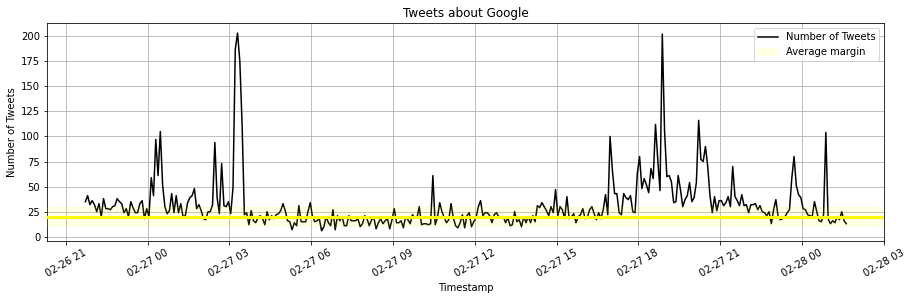

In [10]:
tempData = tempData[:7 * 48,:]
plt.figure(figsize=(15, 4))
plt.plot(tempData[:,0], tempData[:,1], color='black', linestyle='solid')
plt.axhspan(tweetAvg - (stdDev / 2), tweetAvg + (stdDev / 2), color="yellow", alpha=0.1, zorder=5)
plt.axhspan(tweetAvg - 1, tweetAvg + 1, color="yellow", zorder=6)
plt.title("Tweets about Google")
plt.xlabel("Timestamp")
plt.xticks(rotation=30)
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.legend((line1, line2),loc='best')

In [12]:
'''This is a representation of the number of Tweets regarding GOOG\
 over the course of approximately a week. There is an even larger amount of \
 fluctuation regarding how many Tweets are posted regarding Google when\
 compared to AMZN'''

'This is a representation of the number of Tweets regarding GOOG over the course of approximately a week. There is an even larger amount of  fluctuation regarding how many Tweets are posted regarding Google when compared to AMZN'

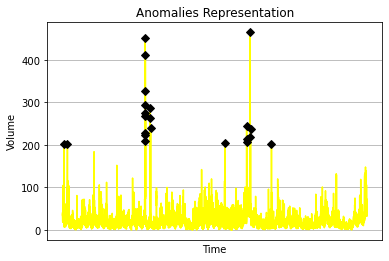

In [14]:
figure, temp = plt.subplots()
temp.plot(dataset.index, dataset['value'], color='yellow')
dates = mdates.YearLocator()
datesFormat = mdates.DateFormatter('%Y')
temp.xaxis.set_major_locator(dates)
temp.xaxis.set_major_formatter(datesFormat)
temp.set(xlabel='Time', ylabel='Volume',title='Anomalies Representation')
temp.grid()
for i, row in dataset.iterrows():
    if (row['value'] > 200):
        temp.plot(i, dataset['value'][i], 'D', color='black')
        
plt.grid(True)
plt.show()

In [15]:
'''Here we can see the largest anomalies within the dataset, marked by the black\
 diamonds on the graph.'''

'Here we can see the largest anomalies within the dataset, marked by the black diamonds on the graph.'

In [16]:
from sklearn.ensemble import IsolationForest
tempData = np.array(dataset)
tempData[:,0] = range(len(dataset))
forest = IsolationForest(contamination=.004)
forestPred = forest.fit_predict(tempData)
dataAnoms = dataset.merge(pd.Series(forestPred, name="anomalies"), left_index=True, right_index=True)
dataAnoms.head()

,timestamp,value,scores,anomalies
0,2015-02-26 21:42:53,35,0.5625,1
1,2015-02-26 21:47:53,41,1.1025,1
2,2015-02-26 21:52:53,32,0.3600,1
3,2015-02-26 21:57:53,36,0.6400,1
4,2015-02-26 22:02:53,32,0.3600,1


In [17]:
'''After applying Isolation Forest to the dataset, we can display\
 the features that have been marked as an anomaly. A graphical depiction of \
 the anomalies over time is shown in the graph below.'''

'After applying Isolation Forest to the dataset, we can display the features that have been marked as an anomaly. A graphical depiction of  the anomalies over time is shown in the graph below.'

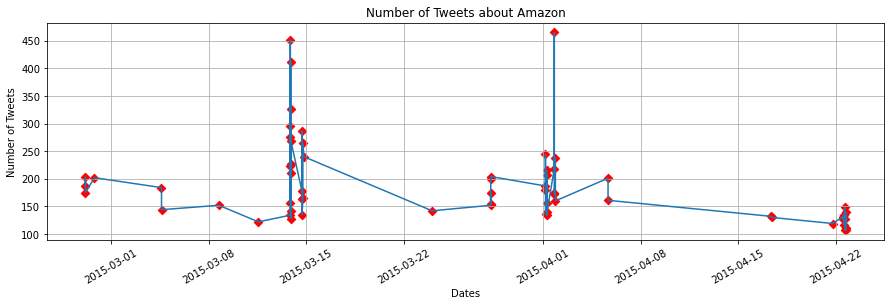

In [18]:
from sklearn.neighbors import LocalOutlierFactor
anomalies = dataAnoms.loc[dataAnoms["anomalies"] != 1]
anomData = anomalies.apply(lambda row: np.array(list((row["timestamp"], row["value"]))), axis=1)
anomData = np.array(list(anomData))
plt.figure(figsize=(15, 4))
plt.plot(anomData[:,0], anomData[:,1], label="Data")
plt.title("Number of Tweets about Amazon")
plt.xlabel("Dates")
plt.xticks(rotation=30)
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.scatter(anomData[:,0], anomData[:,1], color="red", marker="D", label="anomalies")

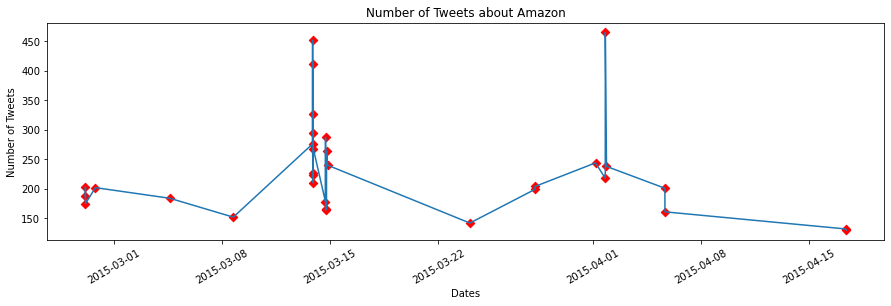

In [19]:
tempData = np.array(dataset)
tempData[:,0] = range(len(dataset))
model = LocalOutlierFactor(n_neighbors=50, contamination=.002)
pred = model.fit_predict(tempData)
dataAnom = dataset.merge(pd.Series(pred, name="anomalies"), left_index=True, right_index=True)
anomalies = dataAnom.loc[dataAnom["anomalies"] != 1]
anomData = anomalies.apply(lambda row: np.array(list((row["timestamp"], row["value"]))), axis=1)
anomData = np.array(list(anomData))
#show_anomaly_data(anomalies)
plt.figure(figsize=(15, 4))
plt.plot(anomData[:,0], anomData[:,1], label="Data")
plt.title("Number of Tweets about Amazon")
plt.xlabel("Dates")
plt.xticks(rotation=30)
plt.ylabel("Number of Tweets")
plt.scatter(anomData[:,0], anomData[:,1], color="red", marker="D", label="anomalies")

In [20]:
'''Next I applied Local Outlier Factor to the dataset in order to see\
 how one 'Feature Engineering' model might perform in comparison to another. \
 Here LOF found far fewer anomalies than Isolation Forest, but the majority \
 of anomalies were found by both models.'''

"Next I applied Local Outlier Factor to the dataset in order to see how one 'Feature Engineering' model might perform in comparison to another.  Here LOF found far fewer anomalies than Isolation Forest, but the majority  of anomalies were found by both models."